In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


In [2]:
import torch
import monai
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Scrolls_Dataset_Module import Scrolls_Dataset
import matplotlib.patches as patches
from lit_models.UNET_monai_lit import UNET_lit
from monai.visualize import matshow3d

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


2023-04-17 21:31:33,310 - Created a temporary directory at /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmp0gflo2lp
2023-04-17 21:31:33,310 - Writing /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmp0gflo2lp/_remote_module_non_scriptable.py


In [3]:
# Initiating Dataset with parameters

# buffer =   -- x,y patchsize for training
# z_start =  --  Offset of slices in the z direction
# z_dim =    -- Number of slices in the z direction. Max value is (64 - z_start)
# validation_rect =  -- rectangle removed for validation set
# shared_height = -- Height to resize all scrolls
# scroll_fragments = -- scrolls to be used 

dataset = Scrolls_Dataset(
                monai= True,
    
                buffer = 32,
                 z_start = 26,
                 z_dim = 16,
                 validation_rect = (1100, 3500, 700, 950),
                shared_height = 8000,
                 downsampling =None,
                 scroll_fragments = [1],#[1,2,3],
                 stage = 'train',
                 shuffle=True,
                 batch_size=1,
                 num_workers =4 ,
                 on_gpu= False,
                          
                         )


In [4]:
# prepeare data, by processng images and loading dataloader

dataset.prepare_data()

16it [00:06,  2.34it/s]


In [5]:
#lit_model = UNET_lit(z_dim = dataset.z_dim)

In [6]:
trainer = pl.Trainer(
        accelerator='mps',
        benchmark=True,
        max_epochs=20,
        check_val_every_n_epoch= 1,
        devices=1,
        #fast_dev_run=fast_dev_run,
        logger=pl.loggers.CSVLogger(save_dir='logs/'),
        log_every_n_steps=1,
        
        overfit_batches=0,
        precision=16,
         accumulate_grad_batches=8,)

trainer.fit(lit_model, datamodule=dataset)

2023-04-17 21:31:43,055 - Using 16bit Automatic Mixed Precision (AMP)
2023-04-17 21:31:43,065 - GPU available: True (mps), used: True
2023-04-17 21:31:43,066 - TPU available: False, using: 0 TPU cores
2023-04-17 21:31:43,066 - IPU available: False, using: 0 IPUs
2023-04-17 21:31:43,066 - HPU available: False, using: 0 HPUs


/Users/gregory/anaconda3/lib/python3.10/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


NameError: name 'lit_model' is not defined

In [ ]:
len(dataset.train_pixels)

In [7]:
model = monai.networks.nets.UNet(
                spatial_dims=2,
                in_channels=16, #z_dim
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                dropout=.2,
            )

In [ ]:
dataloader = iter(dataset.train_dataloader())
train_tensor = None
train_label = None
train_mask = None
for i in range(1):
    # Get image and label from train data -- change number for different ones
    #print(next(dataloader))
    subvolume, inklabel, mask = next(dataloader)
    print('subvolume shape:',subvolume.shape)
    print('inklabel shape:',inklabel.shape)
    print('mask shape', mask.shape)
    train_tensor = subvolume
    train_label = inklabel
    train_mask = mask

In [ ]:
train_tensor.squeeze(1).shape

In [ ]:
res = model(train_tensor.squeeze(1))
print(res.shape)

In [ ]:
res = model(train_tensor.squeeze(1))
print(res.shape)
loss = monai.losses.DiceLoss(sigmoid=True)
loss = monai.losses.MaskedLoss(loss)
value = loss(res, train_label, train_mask)


In [ ]:
print(value)

In [ ]:
dataset.image_tensors.shape

In [ ]:
dataset.mask.shape

In [ ]:
dataset.label_tensors.shape

### MONAI Dataloader Work

In [8]:
from monai.data import ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter, DataLoader
from monai.data import DataLoader
from monai.transforms import (
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import first

In [9]:


array_ds = monai.data.ArrayDataset(img= dataset.image_tensors.unsqueeze(0), 
                                   #img_transform = transform,
                                   seg=dataset.mask.unsqueeze(0).unsqueeze(0),
                                   #seg_transform = transform,
                                   #label_transform =transform,
                                   labels = dataset.label_tensors.unsqueeze(0).unsqueeze(0) 
                                  )

patch_iter = monai.data.PatchIter(patch_size=( 512, 512))

def img_seg_iter(x):
    for im, seg, label in zip(patch_iter(x[0]), patch_iter(x[1]),patch_iter(x[2]) ):
        # uncomment this to confirm the coordinates
        #print("coord img:", im[1].flatten(), "coord seg:", seg[1].flatten())
        yield ((im[0], seg[0], label[0]),)
        
patched_ds = monai.data.GridPatchDataset(array_ds, patch_iter = img_seg_iter, with_coordinates=False)



torch.Size([2, 16, 512, 512]) torch.Size([2, 1, 512, 512]) torch.Size([2, 1, 512, 512])
torch.Size([2, 16, 512, 512]) torch.Size([2, 1, 512, 512]) torch.Size([2, 1, 512, 512])
torch.Size([2, 16, 512, 512]) torch.Size([2, 1, 512, 512]) torch.Size([2, 1, 512, 512])
torch.Size([2, 16, 512, 512]) torch.Size([2, 1, 512, 512]) torch.Size([2, 1, 512, 512])


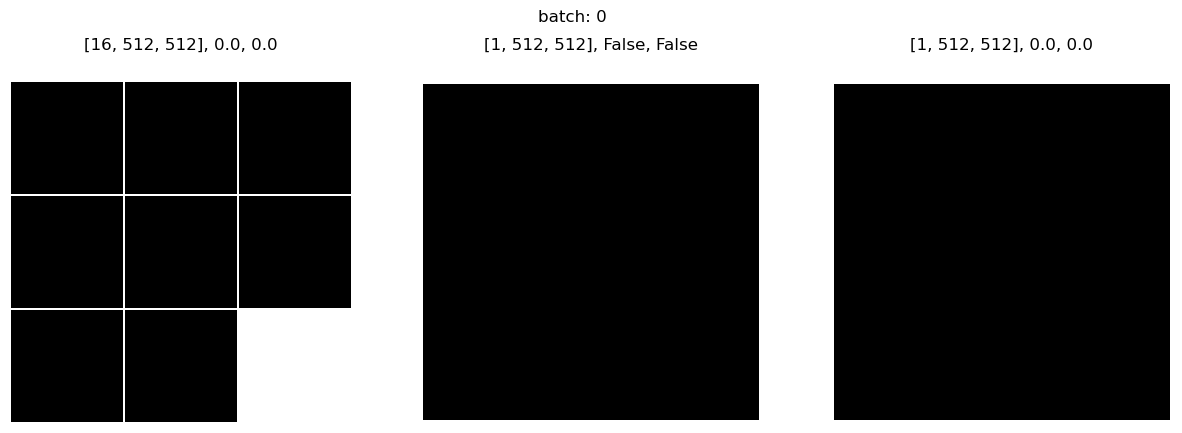

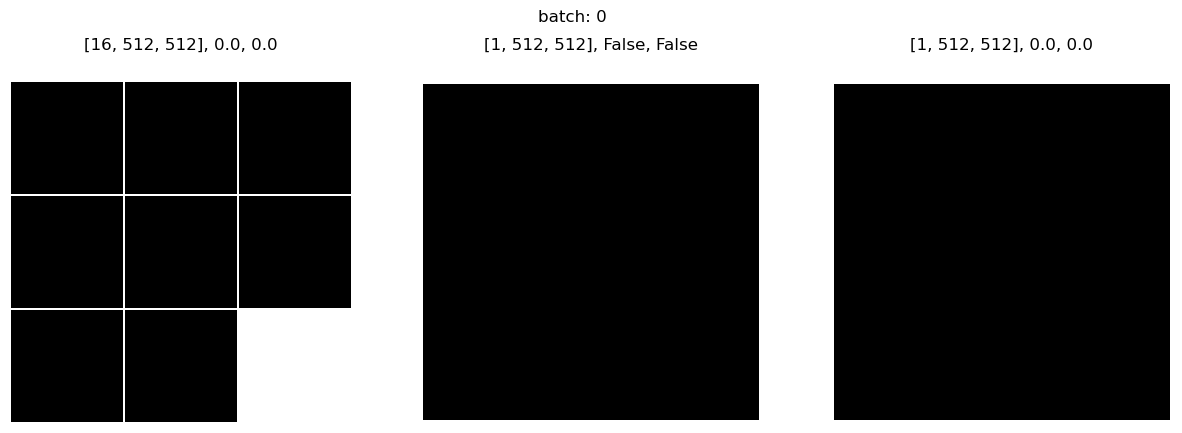

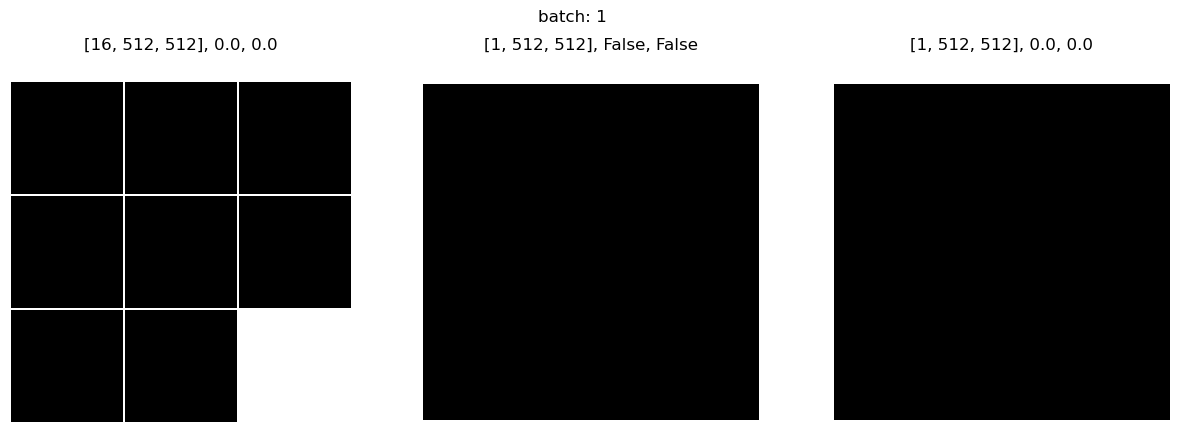

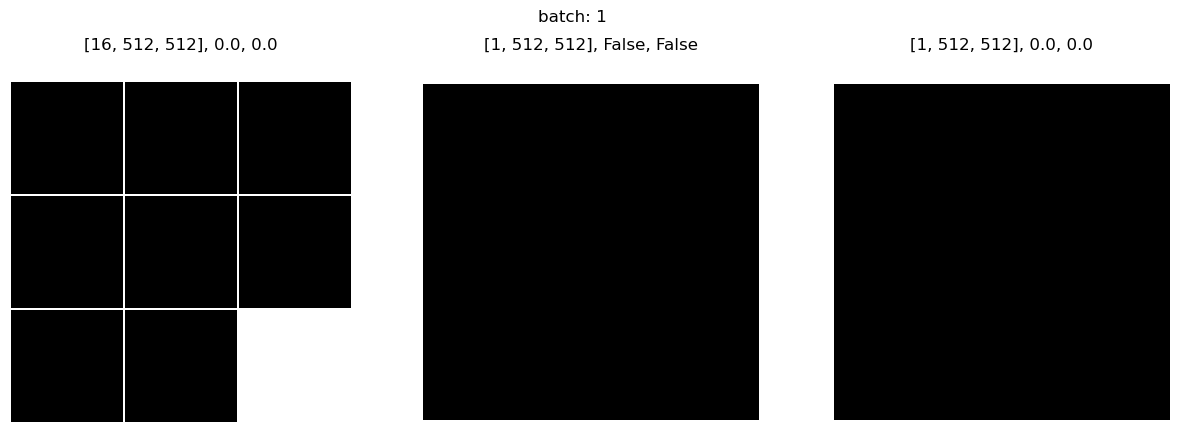

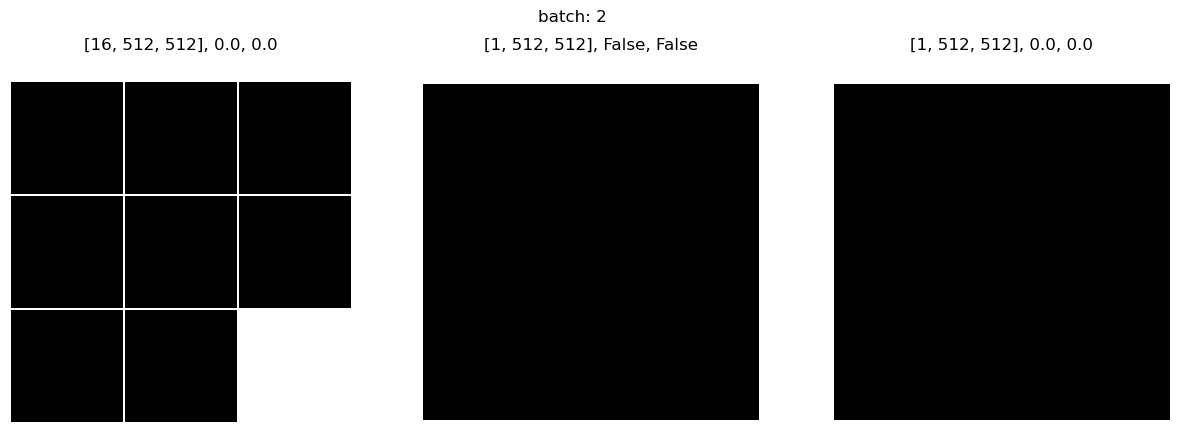

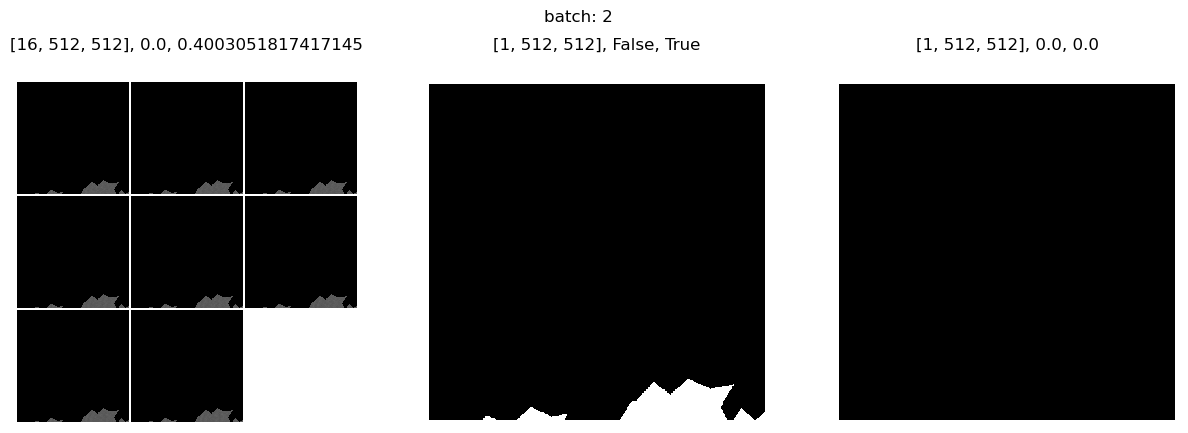

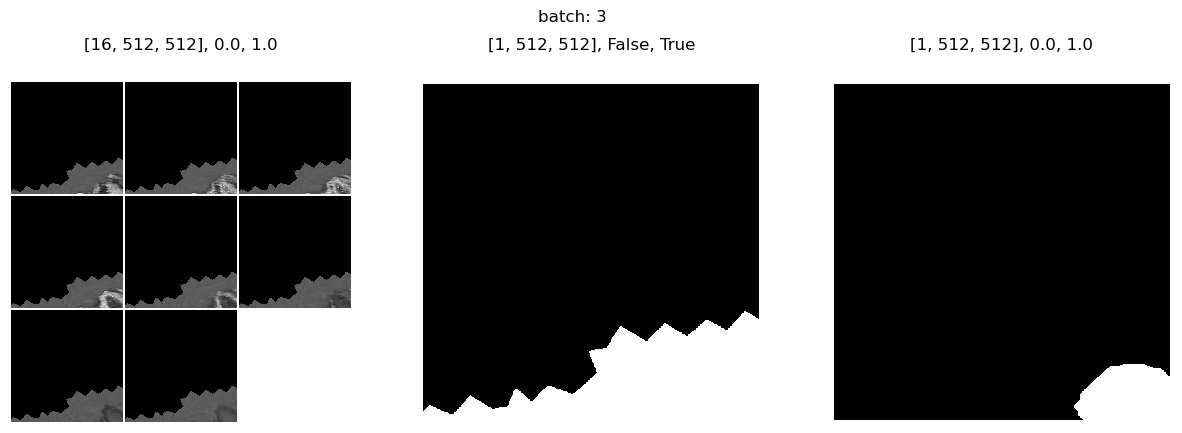

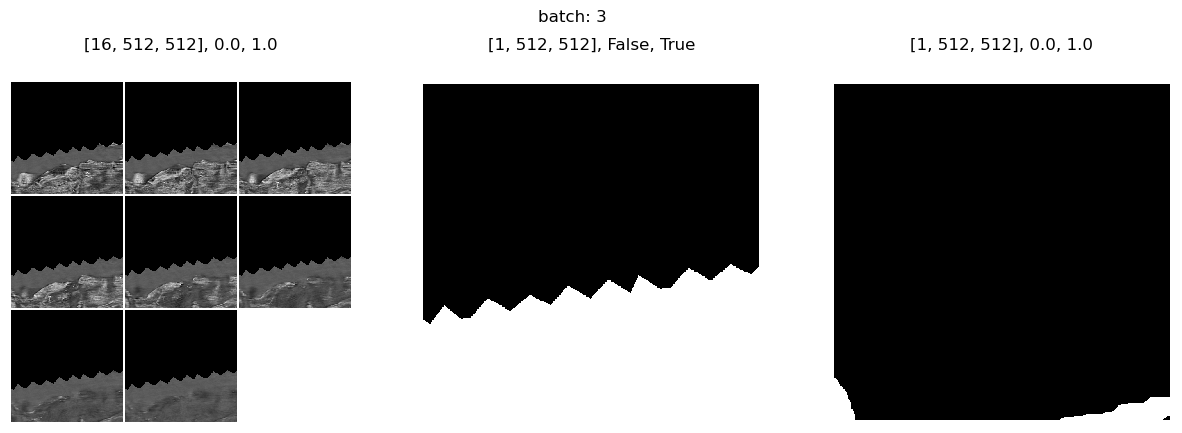

In [10]:
monai_dataloader = DataLoader(
            patched_ds,
            batch_size=2,
            #shuffle=True,
            num_workers=0,
        )
volumes_tensor = None
masks_tensor = None
labels_tensor = None
for batch_idx, batch in enumerate(monai_dataloader):
    if batch_idx>3:
        break
    volumes, masks, labels = batch
    print(volumes.shape, masks.shape, labels.shape)
    volumes_tensor, masks_tensor, labels_tensor =  volumes, masks, labels 
    for volume, mask , label in zip(volumes, masks, labels):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        plt.suptitle(f"batch: {batch_idx}") 
        
        for idx, image in enumerate((volume, mask, label)):
            matshow3d(
                volume=image,
                fig=axes[idx],
                title=f"{list(image.shape)}, {image.min().item()}, {image.max().item()}",
                vmin=0.0,
                vmax=1.0,
                every_n=2,
                fill_value=1.0,
                margin=4,
                cmap="gray",
            )


In [12]:
print(volumes_tensor.shape, masks_tensor.shape, labels_tensor.shape )

torch.Size([2, 16, 512, 512]) torch.Size([2, 1, 512, 512]) torch.Size([2, 1, 512, 512])


In [13]:
model = monai.networks.nets.UNet(
                spatial_dims=2,
                in_channels=16, #z_dim
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                dropout=.2,
            )

In [45]:
labels_tensor.shape

torch.Size([2, 1, 512, 512])

In [14]:
res = model(volumes_tensor)
print(res.shape)
loss = monai.losses.DiceLoss(sigmoid=True)
loss = monai.losses.MaskedLoss(loss)
value = loss(res, labels_tensor, masks_tensor)


torch.Size([2, 1, 512, 512])


In [36]:
pred = torch.sigmoid(res.detach()).gt(.4).int()

In [51]:
accuracy = (pred == labels_tensor).sum().float().div(labels_tensor.size(0)*labels_tensor.size(2)**2)

In [53]:
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

In [54]:
fbeta = fbeta_score( torch.sigmoid(res), labels_tensor, .4)

In [55]:
fbeta

tensor(0.0252)

In [58]:
from torchmetrics import FBetaScore
fbeta_torch = FBetaScore( task="binary", beta=.5, threshold=.4)
fbeta_from_torch = fbeta_torch(torch.sigmoid(res), labels_tensor)
print(fbeta_from_torch)

tensor(0.0252)


In [ ]:
monai_dataloader_val = DataLoader(
            array_ds,
            batch_size=2,
            #shuffle=True,
            num_workers=0,
        )

In [ ]:
for batch_idx, batch in enumerate(monai_dataloader_val):
    if batch_idx>3:
        break
    volumes, masks, labels = batch
    print(volumes.shape, masks.shape, labels.shape)

In [ ]:
x,y = dataset.pixels[900000]
print(y,x)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(dataset.label_tensors)

BUFFER = 256

patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(patch)

In [ ]:
x,y = y,x
BUFFER = 256
print(y,x)

In [ ]:
image = dataset.image_tensors[:, y - BUFFER:y + BUFFER , x - BUFFER:x + BUFFER ].view(1, 8, BUFFER * 2 ,BUFFER * 2)





In [ ]:
label =dataset.label_tensors[ y - BUFFER:y + BUFFER  , x - BUFFER:x + BUFFER  ].view(1, BUFFER * 2 ,BUFFER * 2 )










In [ ]:
label.shape

In [ ]:
label.dtype

In [ ]:
fig, ax = plt.subplots()
ax.imshow(dataset.mask)

BUFFER = 256

patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(patch)

In [ ]:
print(dataset.mask.shape)
print(dataset.label_tensors.shape)

In [ ]:
y,x = x,y
mask = dataset.mask[ y - BUFFER:y + BUFFER  , x - BUFFER:x + BUFFER  ].view(1, BUFFER * 2 ,BUFFER * 2 )
plt.imshow(mask)

In [ ]:
plt.imshow(label)

In [ ]:
label.shape

In [ ]:
image.shape

In [ ]:
fig, ax = plt.subplots()


In [ ]:
dataset.image_tensors.shape

In [ ]:
dataset.label_tensors.shape

In [ ]:
train_tensor.shape

In [ ]:
res = model(train_tensor.squeeze(1))
print(res.shape)
print(train_label.shape)
loss = monai.losses.DiceLoss(sigmoid=True)
loss = monai.losses.MaskedLoss(loss)
value = loss(res, train_label)

In [ ]:
print(res.shape)
print(train_label.shape)

In [ ]:
loss = monai.losses.DiceLoss(sigmoid=True)
    
loss = monai.losses.MaskedLoss(loss)

In [ ]:
value = loss(res, train_label)